In [ ]:
import os
import tempfile
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import osmnx as ox
import pandas as pd
import tqdm
from meteostations.clients import agrometeo

import tstore

/home/martibosch/mambaforge/envs/tstore/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Your first TStore

In this tutorial, we will build a TStore of observations from the meteorological stations operated by [Agrometeo](https://www.agrometeo.ch/) [<sup>1</sup>](#agrometeo) in the Canton of Vaud, Switzerland during the last 5 years. We will use the [meteostations-geopy](https://github.com/martibosch/metastations-geopy) package to fetch the data. For this tutorial, you need to install the `feat-multivar-df` branch, e.g.:

```
pip install git+ssh://git@github.com/martibosch/meteostations-geopy.git@feat-multivar-df
```

Let us first have a look at the stations' locations:

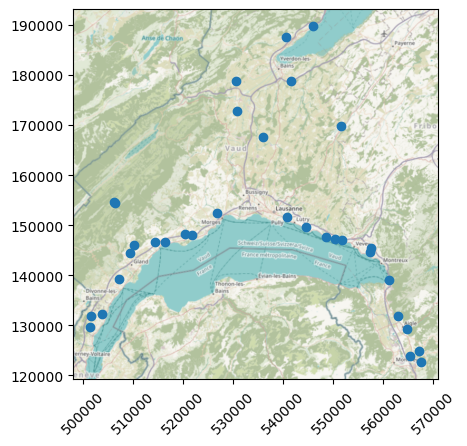

In [ ]:
region = "Canton de Vaud"

client = agrometeo.AgrometeoClient(region)

ax = client.stations_gdf.plot()
cx.add_basemap(ax=ax, crs=client.stations_gdf.crs, attribution="")
ax.tick_params(axis="x", labelrotation=45)
# ax.get_figure().savefig("")

Likewise many other APIs, Agrometeo limits the amount of data that can be fetched in a single request. Therefore, we will fetch the data in chunks of 1 month and concatenate it. Let's start by looking at 1-month chunk of data:

In [ ]:
variables = ["temperature", "water_vapour", "precipitation"]
start_date = "2021-01-01"
end_date = "2021-01-31"
client.get_ts_df(variables, start_date, end_date)

station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2021-01-01 00:00:00         2.2         99.0           0.2         2.5   
2021-01-01 00:10:00         2.3         99.0           0.2         2.6   
2021-01-01 00:20:00         2.4         99.0           0.1         2.8   
2021-01-01 00:30:00         2.4         99.0           0.2         2.8   
2021-01-01 00:40:00         2.5         99.0           0.2         2.8   
...                         ...          ...           ...         ...   
2021-01-31 23:10:00         5.7         99.0           0.0         6.6   
2021-01-31 23:20:00         5.9         99.0           0.4         6.6   
2021-01-31 23:30:00         6.1         99.0           0.2         6.5   
2021-01-31 23:40:00         6.1         98.0           0.3         6.5   
2021-01-31 23:50:00         6.1         99.0           0.3         6.5   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00         96.0           0.0         2.3         94.0   
2021-01-01 00:10:00         96.0           0.2         2.4         94.0   
2021-01-01 00:20:00         95.0           0.1         2.4         94.0   
2021-01-01 00:30:00         94.0           0.2         2.4         94.0   
2021-01-01 00:40:00         94.0           0.1         2.5         94.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00         93.0           0.5         5.7         96.0   
2021-01-31 23:20:00         94.0           0.4         6.0         95.0   
2021-01-31 23:30:00         94.0           0.4         6.1         95.0   
2021-01-31 23:40:00         95.0           0.3         6.2         94.0   
2021-01-31 23:50:00         96.0           0.9         6.2         94.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2021-01-01 00:00:00           0.2         3.2  ...           0.5         0.1   
2021-01-01 00:10:00           0.2         3.1  ...           0.4         0.0   
2021-01-01 00:20:00           0.2         3.3  ...           0.2        -0.0   
2021-01-01 00:30:00           0.2         3.1  ...           0.3         0.0   
2021-01-01 00:40:00           0.2         3.0  ...           0.3         0.1   
...                           ...         ...  ...           ...         ...   
2021-01-31 23:10:00           0.0         5.7  ...           0.1         5.6   
2021-01-31 23:20:00           0.6         5.8  ...           0.4         5.6   
2021-01-31 23:30:00           0.2         6.0  ...           0.0         5.7   
2021-01-31 23:40:00           0.4         5.8  ...           0.2         5.4   
2021-01-31 23:50:00           0.2         6.0  ...           0.2         5.3   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00        100.0           0.0         0.3        100.0   
2021-01-01 00:10:00        100.0           0.0         0.3        100.0   
2021-01-01 00:20:00        100.0           0.0         0.2        100.0   
2021-01-01 00:30:00        100.0           0.0         0.2        100.0   
2021-01-01 00:40:00        100.0           0.0         0.2        100.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00        100.0           0.1         6.6         88.0   
2021-01-31 23:20:00        100.0         

Let us now iteratively assemble 5 years of data:

In [ ]:
num_years = 5
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

yesterday = datetime.now().replace(
    hour=0,
    minute=0,
    second=0,
    microsecond=0,
) - timedelta(days=1)
date_range = pd.date_range(
    yesterday - timedelta(days=365 * num_years),
    yesterday,
    freq=freq,
)

ts_df = pd.concat(
    [
        client.get_ts_df(variables, start_date, end_date - timedelta(days=1))
        for start_date, end_date in tqdm.tqdm(
            zip(date_range[:-1], date_range[1:]),
            total=len(date_range) - 1,
        )
    ],
)
ts_df

100%|█████████████████████████████████████████████████| 59/59 [01:25<00:00,  1.45s/it]


station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2019-09-01 00:00:00        22.4         61.0           0.0        22.7   
2019-09-01 00:10:00        22.4         61.0           0.0        22.5   
2019-09-01 00:20:00        22.5         60.0           0.0        22.4   
2019-09-01 00:30:00        22.4         60.0           0.0        22.7   
2019-09-01 00:40:00        22.4         60.0           0.0        22.8   
...                         ...          ...           ...         ...   
2024-07-31 23:10:00        20.6         99.0           0.0        22.3   
2024-07-31 23:20:00        20.7         99.0           0.0        22.5   
2024-07-31 23:30:00        21.0         99.0           0.0        22.7   
2024-07-31 23:40:00        21.0         99.0           0.0        22.3   
2024-07-31 23:50:00        20.8         99.0           0.0        21.6   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-09-01 00:00:00         55.0           0.0        22.1         61.0   
2019-09-01 00:10:00         56.0           0.0        22.4         59.0   
2019-09-01 00:20:00         56.0           0.0        22.2         59.0   
2019-09-01 00:30:00         55.0           0.0        22.5         58.0   
2019-09-01 00:40:00         54.0           0.0        22.3         61.0   
...                          ...           ...         ...          ...   
2024-07-31 23:10:00         82.0           0.0        19.9         99.0   
2024-07-31 23:20:00         80.0           0.0        20.0         99.0   
2024-07-31 23:30:00         78.0           0.0        20.0         99.0   
2024-07-31 23:40:00         78.0           0.0        19.9         99.0   
2024-07-31 23:50:00         82.0           0.0        19.9         99.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2019-09-01 00:00:00           0.0        20.5  ...           0.0        20.8   
2019-09-01 00:10:00           0.0        20.4  ...           0.0        22.1   
2019-09-01 00:20:00           0.0        20.2  ...           0.0        22.6   
2019-09-01 00:30:00           0.0        20.1  ...           0.0        22.7   
2019-09-01 00:40:00           0.0        20.6  ...           0.0        22.7   
...                           ...         ...  ...           ...         ...   
2024-07-31 23:10:00           0.0        22.7  ...           0.0        21.8   
2024-07-31 23:20:00           0.0        23.0  ...           0.0        21.9   
2024-07-31 23:30:00           0.0        23.1  ...           0.0        22.1   
2024-07-31 23:40:00           0.0        22.7  ...           0.0        22.3   
2024-07-31 23:50:00           0.0        20.5  ...           0.0        22.2   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-09-01 00:00:00         75.0           0.0        22.3         79.0   
2019-09-01 00:10:00         58.0           0.0        22.4         78.0   
2019-09-01 00:20:00         55.0           0.0        22.0         82.0   
2019-09-01 00:30:00         53.0           0.0        21.4         87.0   
2019-09-01 00:40:00         54.0           0.0        21.6         84.0   
...                          ...           ...         ...          ...   
2024-07-31 23:10:00         85.0           0.0        23.3         67.0   
2024-07-31 23:20:00         85.0         

###### TODO: implement `to_tstore` method for wide dataframes.

The data frame above corresponds to the "wide" format of the data. In order to build a TStore, we need to transform it into the "long" format. We can do this by stacking the columns of the data frame:

In [ ]:
long_ts_df = ts_df.stack(level=0, future_stack=True).swaplevel().sort_index()
long_ts_df

variable                     temperature  water_vapour  precipitation
station time                                                         
1       2019-09-01 00:00:00         22.4          61.0            0.0
        2019-09-01 00:10:00         22.4          61.0            0.0
        2019-09-01 00:20:00         22.5          60.0            0.0
        2019-09-01 00:30:00         22.4          60.0            0.0
        2019-09-01 00:40:00         22.4          60.0            0.0
...                                  ...           ...            ...
305     2024-07-31 23:10:00         24.6          67.0            0.0
        2024-07-31 23:20:00         24.7          65.0            0.0
        2024-07-31 23:30:00         24.8          67.0            0.0
        2024-07-31 23:40:00         24.4          77.0            0.1
        2024-07-31 23:50:00         23.4          98.0            0.0

[8534361 rows x 3 columns]

We can now dump this data frame into a tstore:

In [ ]:
def get_tstore_filepaths(base_dir):
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]


tstore_dir = "agrometeo-tstore"
tstore_structure = "id-var"
overwrite = True
id_var = "station"
time_var = "time"
# static_variables = ["variable"]
geometry = client.stations_gdf.rename_axis(
    index={client.stations_gdf.index.name: id_var},
)["geometry"].reset_index()

# Same partitioning for all TS
partitioning = "year"

tslong = tstore.TSLong(
    long_ts_df.reset_index(),
    id_var,
    time_var=time_var,
    ts_vars=variables,
    geometry=geometry,
)
start = time.time()
tslong.to_tstore(
    # TSTORE options
    tstore_dir,
    # TSTORE options
    partitioning=partitioning,
    tstore_structure=tstore_structure,
    overwrite=overwrite,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")
tstore_filepaths = get_tstore_filepaths(tstore_dir)
for line in tstore_filepaths[:5] + ["..."] + tstore_filepaths[-5:]:
    if line.endswith("parquet"):
        print(line, f"({path.getsize(line)/1e6} MB)")
    else:
        print(line)

total_size = sum(path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths)
print(f"Total size: {total_size/1e6} MB (in {len(tstore_filepaths)} files)")
start = time.time()
ts_df = tstore.open_tslong(tstore_dir, backend="pandas")
print(f"Read tstore in: {time.time() - start:.2f} s")

Dumped tstore in: 5.17 s
agrometeo-tstore/tstore_metadata.yaml
agrometeo-tstore/_attributes.parquet (0.008002 MB)
agrometeo-tstore/96/temperature/_common_metadata
agrometeo-tstore/96/temperature/_metadata
agrometeo-tstore/96/temperature/year=2020/part-0.parquet (0.539856 MB)
...
agrometeo-tstore/27/precipitation/year=2021/part-0.parquet (0.48278 MB)
agrometeo-tstore/27/precipitation/year=2019/part-0.parquet (0.161376 MB)
agrometeo-tstore/27/precipitation/year=2022/part-0.parquet (0.482212 MB)
agrometeo-tstore/27/precipitation/year=2023/part-0.parquet (0.482844 MB)
agrometeo-tstore/27/precipitation/year=2024/part-0.parquet (0.27916 MB)
Total size: 249.884152 MB (in 794 files)
Read tstore in: 31.33 s


We can see that this creates a hierarchical structure in which for each station id, a folder is created for variable. Each variable folder is composed of metadata as well as the actual data partitioned by months (as specified with the `partitioning` argument). Note that the file sizes are quite small which is likely inefficient [<sup>2</sup>](#parquet-file-size).

## Filtering at read time

Note that we may be interested in reading a single variable, in which case reading times are dramatically reduced:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_df = tstore.open_tslong(tstore_dir, ts_variables=variable, backend="pandas")
print(f"Read tstore for {variable} in: {time.time() - start:.2f} s")
T_ts_df

Read tstore for temperature in: 2.09 s


,station,temperature
time,,
2019-09-01 00:00:00,78,15.6
2019-09-01 00:10:00,78,15.6
2019-09-01 00:20:00,78,15.8
2019-09-01 00:30:00,78,15.9
2019-09-01 00:40:00,78,16.1
...,...,...
2023-12-31 23:10:00,27,3.8
2023-12-31 23:20:00,27,3.7
2023-12-31 23:30:00,27,3.6


We may only be interested in loading a specific subset of the data, e.g., time period:

In [ ]:
start = time.time()
ts_2021_df = tstore.open_tslong(
    tstore_dir,
    start_time="2021-01-01",
    end_time="2021-01-31",
    inclusive="both",
    backend="pandas",
)
print(f"Read tstore for one year in: {time.time() - start:.2f} s")

Read tstore for one year in: 2.30 s


which can result in important performance gains as filters are applied at read time. We can further filter the time range and target variables simoultaneously:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_2021_df = tstore.open_tslong(
    tstore_dir,
    ts_variables=variable,
    start_time="2021-01-01",
    end_time="2021-01-31",
    backend="pandas",
)
print(f"Read tstore for one variable, one year in: {time.time() - start:.2f} s")

Read tstore for one variable, one year in: 0.61 s


## TSDF: the (geo) time series data frame

We can also lazily read the whole TStore into a `TSDF` object:

In [ ]:
tsdf = tstore.open_tsdf(tstore_dir)
tsdf.head()

,station,temperature,water_vapour,precipitation,geometry
0,1,TS[shape=(Delayed('int-dab79b77-5b8f-4252-9de1...,TS[shape=(Delayed('int-193eb739-3820-4a6e-8f8b...,TS[shape=(Delayed('int-62d167cf-7ec2-44ee-9318...,POINT (521720.000 148080.000)
1,3,TS[shape=(Delayed('int-2e6b6c99-074b-4185-b16c...,TS[shape=(Delayed('int-457032eb-012f-4db5-8f50...,TS[shape=(Delayed('int-f42688e5-09bb-4ef4-8767...,POINT (507130.000 139310.000)
2,4,TS[shape=(Delayed('int-a0ce6180-2d47-4de6-aa1e...,TS[shape=(Delayed('int-d8be737b-d259-4635-8ad1...,TS[shape=(Delayed('int-e36d623f-3b3a-4c10-b94e...,POINT (520355.000 148210.000)
3,10,TS[shape=(Delayed('int-44eca260-487f-469d-98bf...,TS[shape=(Delayed('int-5c6abbe6-c373-4a3b-b3bb...,TS[shape=(Delayed('int-d7303769-6427-4e7b-b9eb...,POINT (557241.000 144716.000)
4,13,TS[shape=(Delayed('int-c5163a73-9363-4b52-ac4c...,TS[shape=(Delayed('int-de3d0880-944a-4386-8589...,TS[shape=(Delayed('int-404278c9-8f87-4a87-b8b9...,POINT (540810.000 151565.000)


Since we provided the geographic location of the stations when writing the TStore, the `TSDF` object will be based on geopandas, with a geometry column that allows performing geographic operations:

In [ ]:
district_geom = (
    ox.geocode_to_gdf("District de Lavaux-Oron").to_crs(tsdf.crs)["geometry"].iloc[0]
)
tsdf[tsdf["geometry"].within(district_geom)]

,station,temperature,water_vapour,precipitation,geometry
4,13,TS[shape=(Delayed('int-ee5a8846-86ac-4beb-9a68...,TS[shape=(Delayed('int-1ff8da0d-db40-40fe-a1bd...,TS[shape=(Delayed('int-a0a5fc87-8def-4764-a3d6...,POINT (540810.000 151565.000)
11,41,TS[shape=(Delayed('int-33868f04-918d-4a2e-bf30...,TS[shape=(Delayed('int-daa80dd5-d70c-4ce6-ad58...,TS[shape=(Delayed('int-520d4404-97ff-4cc2-b3a8...,POINT (548470.000 147690.000)
29,98,TS[shape=(Delayed('int-1768ff7e-35c4-4193-b208...,TS[shape=(Delayed('int-91b2a488-f508-4a30-8544...,TS[shape=(Delayed('int-65f9e49b-be8e-483d-86f1...,POINT (544528.000 149600.000)
32,305,TS[shape=(Delayed('int-d90fcf63-de62-4ce6-af28...,TS[shape=(Delayed('int-960882a5-96dc-4f63-851b...,TS[shape=(Delayed('int-725b9857-656e-4dc6-96cc...,POINT (550365.000 147190.000)


and use the `TS._obj.compute()` method after selecting the target data, so that only the required files are read:

In [ ]:
tsdf.set_index("station").loc[0, "temperature"]._obj.compute()

variable,temperature
time,
2019-09-01 00:00:00,22.4
2019-09-01 00:10:00,22.4
2019-09-01 00:20:00,22.5
2019-09-01 00:30:00,22.4
2019-09-01 00:40:00,22.4
...,...
2024-07-31 23:10:00,20.6
2024-07-31 23:20:00,20.7
2024-07-31 23:30:00,21.0


###### TODO: better interface to lazily reading tsdf data

Let us now compare the I/O of tstore with a pandas CSV:

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    csv_filepath = path.join(tmp_dir, "foo.csv")
    start = time.time()
    long_ts_df.to_csv(csv_filepath)
    print(f"Dumped csv in: {time.time() - start:.2f} s")
    print(f"Total size: {path.getsize(csv_filepath)/1e6} MB")
    start = time.time()
    ts_df = pd.read_csv(csv_filepath)
    print(f"Read csv in: {time.time() - start:.2f} s")

Dumped csv in: 123.86 s
Total size: 310.633327 MB
Read csv in: 9.64 s


As we can see, dumping the data to a tstore is about 18 times faster and takes about 80% of disk space. Although reading the CSV is about 3.5 times faster than reading the whole tstore, reading subsets of data (e.g., a single variable or a specific time period) can be significantly faster (about 6 times faster to read temperature only) using tstore and only loads the targeted data into memory (unlike the CSV which requires loading all the data).

## Footnotes

1. <span id="agrometeo"></span> Data from Agrometeo belongs to the Swiss Federal Administration, see [the terms and conditions](https://www.admin.ch/gov/en/start/terms-and-conditions.html) for more information.
2. <span id="parquet-file-size"></span> Individual parquet files should be at least of a few houndred MBs in size. See the ["Parquet file format – everything you need to know!" blog post](https://data-mozart.com/parquet-file-format-everything-you-need-to-know) for more details.